In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical   
#from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers, optimizers   #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.callbacks import EarlyStopping
import random

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Set seed for all 
tf.random.set_seed(42) 
random.seed(42)
np.random.seed(42)


In [5]:
# Load Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Add channel dimension (greyscale) and normalize pixel values
train_images = train_images[:,:,:,np.newaxis]/255.0
test_images = test_images[:,:,:,np.newaxis]/255.0

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)


# Adding names to classes, we only have numbers, should we do now OR LATER===??
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']




### Med egen funksjon for å lage CNN:

In [6]:
# Create a function to make the CNN
def create_CNN(eta, lmbd):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same',
                     activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                     activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Have not run this on eta and lamda estimation

    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))

    # 10 neurons for the 10 classes
    model.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(lmbd)))

    #sgd = optimizers.legacy.SGD(learning_rate=eta)
    adam = optimizers.legacy.Adam(learning_rate=eta)
    model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
    return model


In [7]:
epochs = 10 # Relatively small number of epochs to efficiently find optimal values
batch_size = 256 # Relatively large batch size

eta_vals = [0.00001, 0.0001, 0.001, 0.01]

lmbd_vals = [0.00001, 0.0001, 0.001, 0.01]

### CNN med ulike eta- og lambda-verdier

RUN THIS WITH UPDATED ARCHITECTURE!!!

In [8]:
# INITIALIZE EMPTY MATRIX TO STORE RESULTS FOR THE DIFFERENT ETA AND LAMBDA VALUES
CNN_keras = np.zeros((len(eta_vals),len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = create_CNN(eta, lmbd)
        history = CNN.fit(train_images, train_labels, validation_split = 0.2, 
                          batch_size=batch_size, epochs=epochs, 
                          validation_data=(test_images, test_labels))
        scores =  CNN.evaluate(test_images, test_labels, verbose=2) 
        #test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
        CNN_keras[i][j] = CNN 
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1]) # scores[0] is loss...
        print()

Epoch 1/10
235/235 [==============================] - 11s 46ms/step - loss: 2.1575 - accuracy: 0.3928 - val_loss: 1.9492 - val_accuracy: 0.5598
Epoch 2/10
235/235 [==============================] - 10s 43ms/step - loss: 1.6354 - accuracy: 0.6433 - val_loss: 1.3257 - val_accuracy: 0.6917
Epoch 3/10
235/235 [==============================] - 10s 42ms/step - loss: 1.1130 - accuracy: 0.7022 - val_loss: 0.9570 - val_accuracy: 0.7189
Epoch 4/10
235/235 [==============================] - 10s 42ms/step - loss: 0.8618 - accuracy: 0.7383 - val_loss: 0.7961 - val_accuracy: 0.7503
Epoch 5/10
235/235 [==============================] - 10s 42ms/step - loss: 0.7443 - accuracy: 0.7620 - val_loss: 0.7131 - val_accuracy: 0.7646
Epoch 6/10
235/235 [==============================] - 10s 42ms/step - loss: 0.6776 - accuracy: 0.7748 - val_loss: 0.6629 - val_accuracy: 0.7711
Epoch 7/10
235/235 [==============================] - 10s 42ms/step - loss: 0.6342 - accuracy: 0.7836 - val_loss: 0.6265 - val_accuracy:


- På eta = 0.1 og lambda =0.1 blir validation accuracy alltid 0.1. OVERFITTING??? Sammenling ulike CNNS (layers, connected neurons osv) for å finne en bra grid search
- Ulike verdier for eta og lambda?? 
learning rate = [0.0001, 0.001, 0.01]
lambda = [0.001, 0.01, 0.1]

313/313 [==============================] - 1s 2ms/step - loss: 0.7619 - accuracy: 0.8214


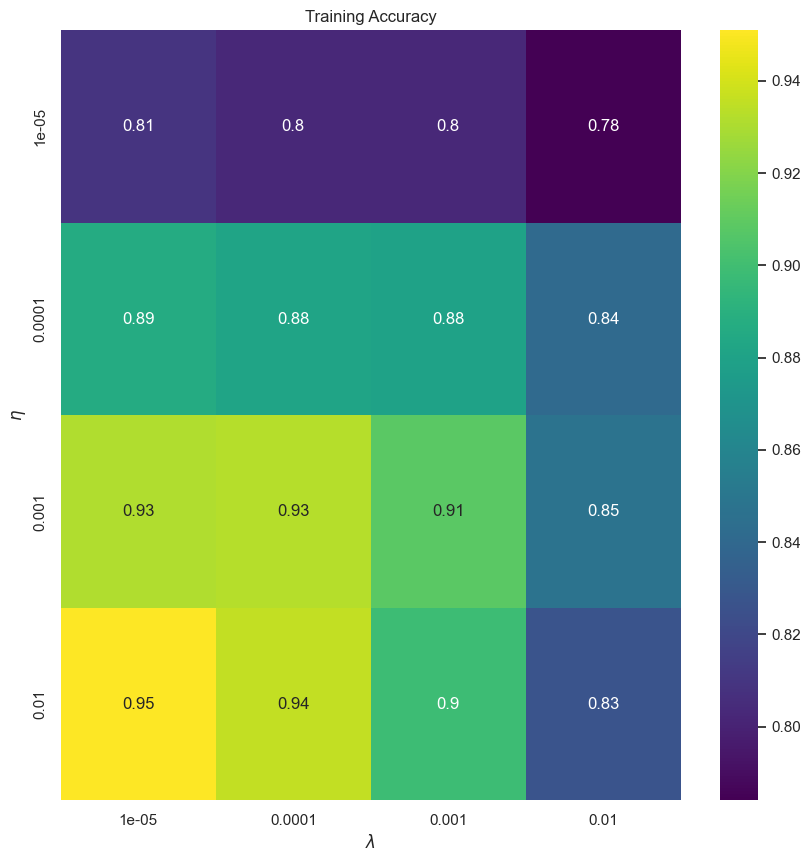

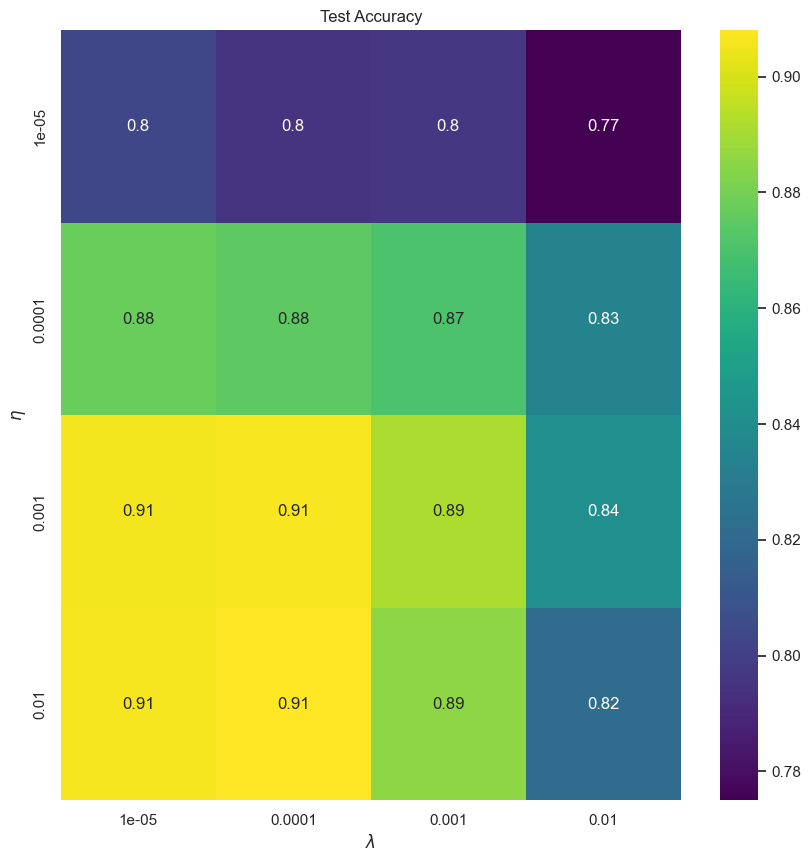

In [9]:
# visual representation of grid search
sns.set_theme(style='darkgrid')

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_keras[i][j]

        train_accuracy[i][j] = CNN.evaluate(train_images, train_labels)[1]
        test_accuracy[i][j] = CNN.evaluate(test_images, test_labels)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy,  annot=True, ax=ax, cmap='viridis',
            xticklabels=eta_vals, 
            yticklabels=lmbd_vals)
ax.set_title('Training Accuracy')
ax.set_ylabel('$\eta$')
ax.set_xlabel('$\lambda$')
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap='viridis', 
            xticklabels=eta_vals, 
            yticklabels=lmbd_vals)
ax.set_title('Test Accuracy')
ax.set_ylabel('$\eta$')
ax.set_xlabel('$\lambda$')
plt.show()


### After grid search, use optimal lambda and eta values:

Epoch 1/100
938/938 [==============================] - 13s 14ms/step - loss: 0.6929 - accuracy: 0.7775 - val_loss: 0.4926 - val_accuracy: 0.8323
Epoch 2/100
938/938 [==============================] - 12s 13ms/step - loss: 0.4502 - accuracy: 0.8507 - val_loss: 0.4593 - val_accuracy: 0.8411
Epoch 3/100
938/938 [==============================] - 11s 12ms/step - loss: 0.4098 - accuracy: 0.8669 - val_loss: 0.4239 - val_accuracy: 0.8526
Epoch 4/100
938/938 [==============================] - 11s 12ms/step - loss: 0.3830 - accuracy: 0.8755 - val_loss: 0.3942 - val_accuracy: 0.8684
Epoch 5/100
938/938 [==============================] - 12s 13ms/step - loss: 0.3633 - accuracy: 0.8834 - val_loss: 0.3876 - val_accuracy: 0.8701
Epoch 6/100
938/938 [==============================] - 12s 13ms/step - loss: 0.3471 - accuracy: 0.8885 - val_loss: 0.3760 - val_accuracy: 0.8759
Epoch 7/100
938/938 [==============================] - 13s 14ms/step - loss: 0.3341 - accuracy: 0.8927 - val_loss: 0.3599 - val_ac

Text(0.5, 1.0, 'Confusion Matrix (eta=0.0001, lambda=0.0001)')

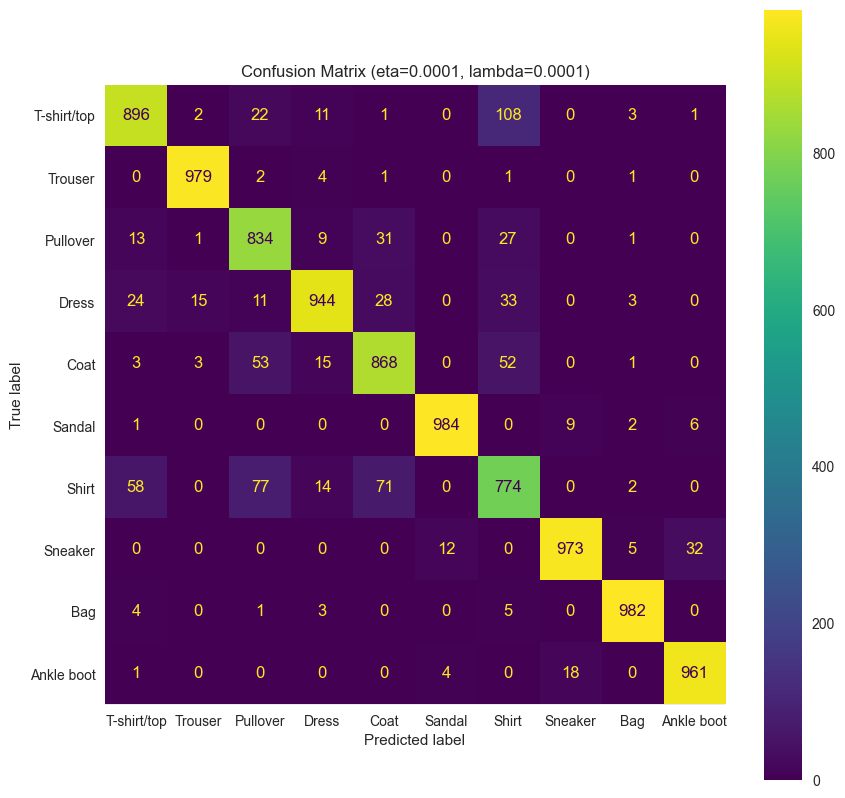

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
'''
This seems okay:
best_eta = 0.001
best_lambda = 0.00001
'''

best_eta = 0.0001
best_lambda = 0.0001

batch_size = 64 # Smaller batch size
epochs = 100 # More epochs

# Create the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Create and train model with optimal values
best_model = create_CNN(best_eta, best_lambda)
history_best = best_model.fit(train_images, train_labels, validation_split = 0.2, batch_size=batch_size,  
                    epochs=epochs, validation_data=(test_images, test_labels), 
                    callbacks=[early_stopping])

# Predict on test set
test_probabilities = best_model.predict(test_images)

# Convert prediction probability into integers 
test_predictions = test_probabilities.argmax(axis=1)

# CONVERT TEST_LABELS FROM ONE HOT ENCODING TO CLASS INDICES
test_labels_indices = test_labels.argmax(axis=1) # convert 2d labels to 1d

# Confusion matrix
cm = confusion_matrix(test_predictions, test_labels_indices)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
ax.grid(False)
plt.title(f'Confusion Matrix (eta={best_eta}, lambda={best_lambda})')


Model is confusing mostly t-shirt, pullover, coat, shirt == similar categories. 

### Plot accuracy for optimal beta and lambda values

/var/folders/yw/7xk1wysd3kvfs513n3xmpn340000gn/T/ipykernel_85580/3838174932.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


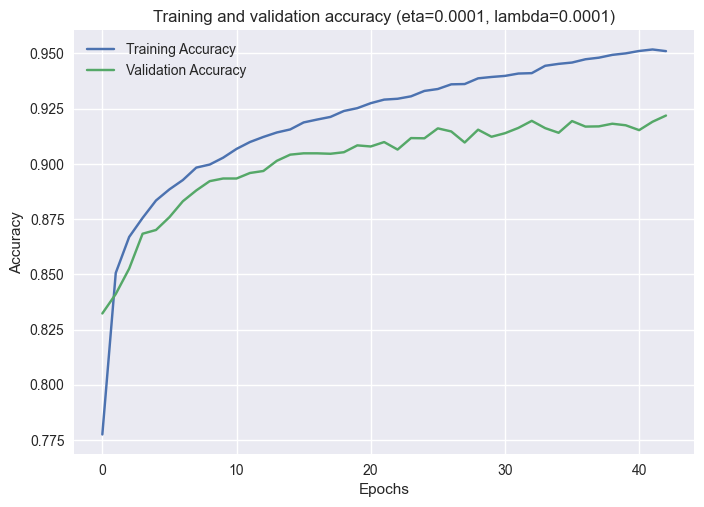

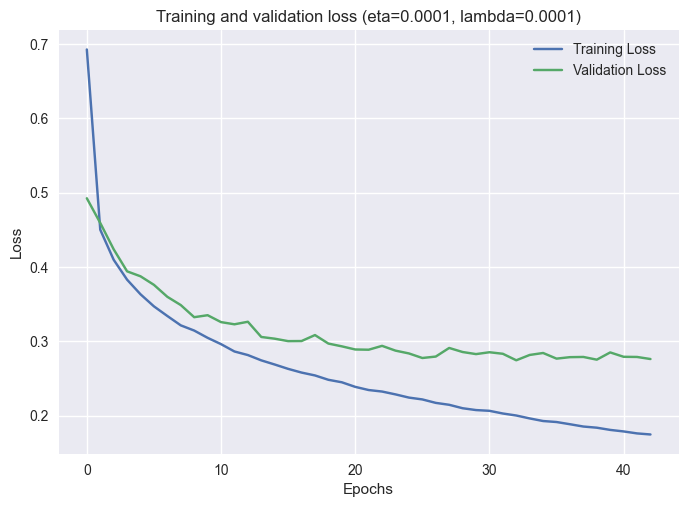

In [15]:
sns.set_theme(style="darkgrid")
plt.style.use('seaborn')


# Plot training and validation accuracy
plt.plot(history_best.history['accuracy'], label='Training Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and validation accuracy (eta={best_eta}, lambda={best_lambda})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title(f'Training and validation loss (eta={best_eta}, lambda={best_lambda})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_indices, test_predictions, target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       0.86      0.90      0.88      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.91      0.83      0.87      1000
       Dress       0.89      0.94      0.92      1000
        Coat       0.87      0.87      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.78      0.77      0.78      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## ----------------

### Predicting on an image

In [232]:
img = test_images[19]

print(img.shape)


(28, 28, 1)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [233]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28, 1)


In [234]:
predictions_single = best_model.predict(img)

print(predictions_single.shape)
print(np.argmax(predictions_single))
print(f'Predicted class: {class_names[np.argmax(predictions_single)]}')
print(f'True class: {class_names[np.argmax(test_labels[19])]}')

1/1 [==============================] - 0s 13ms/step
(1, 10)
0
Predicted class: T-shirt/top
True class: T-shirt/top


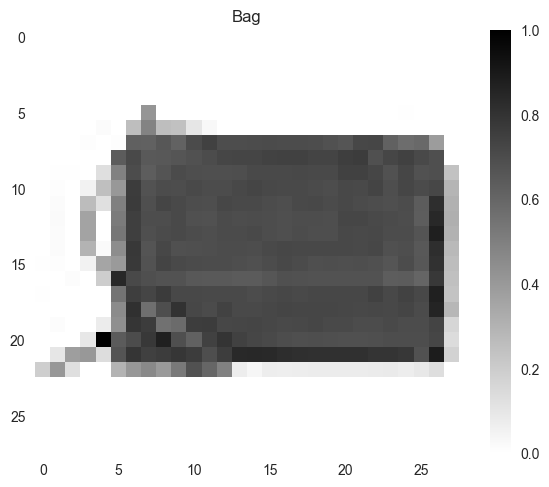

In [220]:
plt.figure()
plt.imshow(test_images[18], cmap=plt.cm.gray_r)
plt.title(f'{class_names[np.argmax(test_labels[18])]}')
plt.colorbar()
plt.grid(False)
plt.show()


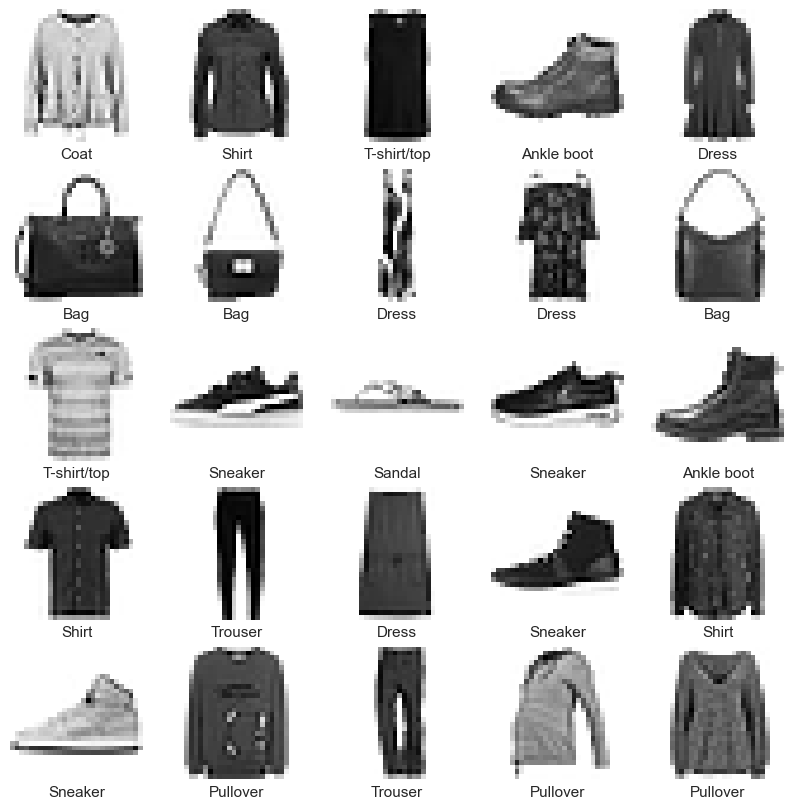

In [245]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i+25], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(test_labels[i+25])])
plt.show()

In [244]:
print(len(range(26,51)))

25
